[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Files in /content: ['.config', 'archive (2).zip', 'sample_data']
Extracted files: ['True.csv', 'Fake.csv']
Dataset shape: (44898, 5)
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans 

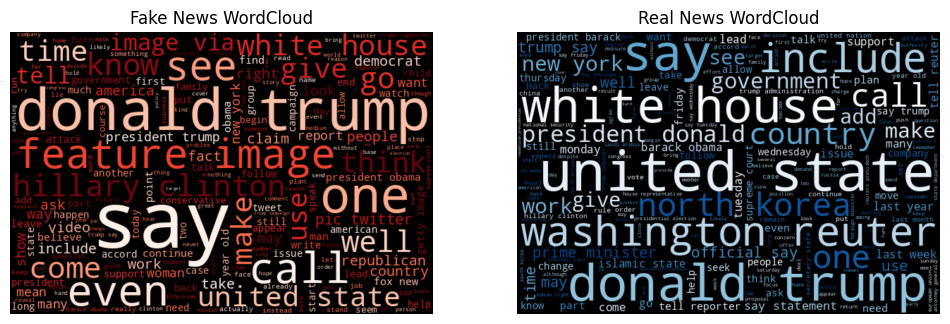

In [ ]:
# ===============================
# Task 3: Fake News Detection
# Google Colab Final Code
# ===============================

# --- Step 1: Install + Import Libraries ---
import pandas as pd
import numpy as np
import re
import os
import zipfile
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# NLTK setup
nltk.download("stopwords")
from nltk.corpus import stopwords

# SpaCy setup
!python -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

# --- Step 2: Locate Dataset ---
# Check files in content (after you upload archive(2).zip OR CSVs)
print("Files in /content:", os.listdir("/content"))

dataset_path = "/content/archive (2).zip"   # Change if file has diff name
extract_path = "/content/news_data"

# Try to unzip if it's a zip file
if dataset_path.endswith(".zip"):
    try:
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        files = os.listdir(extract_path)
        print("Extracted files:", files)
        fake_path = [os.path.join(extract_path,f) for f in files if "Fake" in f][0]
        true_path = [os.path.join(extract_path,f) for f in files if "True" in f][0]
    except:
        print("❌ Could not read as zip. Assuming CSVs are directly in /content")
        fake_path = "/content/Fake.csv"
        true_path = "/content/True.csv"
else:
    # If you uploaded CSVs directly
    fake_path = "/content/Fake.csv"
    true_path = "/content/True.csv"

# --- Step 3: Load Data ---
fake = pd.read_csv(fake_path)
true = pd.read_csv(true_path)

fake["label"] = 0   # Fake = 0
true["label"] = 1   # Real = 1

data = pd.concat([fake, true], axis=0).reset_index(drop=True)
print("Dataset shape:", data.shape)
print(data.head())

# --- Step 4: Preprocessing ---
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", str(text))
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct and len(token.text) > 2]
    return " ".join(tokens)

# Combine title + text, then clean
data["content"] = (data["title"].astype(str) + " " + data["text"].astype(str))
data["cleaned"] = data["content"].apply(preprocess_text)

print("Sample cleaned text:\n", data["cleaned"].iloc[0][:300])

# --- Step 5: TF-IDF Vectorization ---
X = data["cleaned"]
y = data["label"]

vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

# --- Step 6: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)

# --- Step 7: Train Models ---
# Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Support Vector Machine (Linear SVC)
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# --- Step 8: Evaluation ---
print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

print("\n=== Support Vector Machine ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# --- Step 9: Bonus WordClouds ---
fake_words = " ".join(data[data["label"]==0]["cleaned"])
real_words = " ".join(data[data["label"]==1]["cleaned"])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
wc_fake = WordCloud(width=600, height=400, background_color="black", colormap="Reds").generate(fake_words)
plt.imshow(wc_fake, interpolation="bilinear")
plt.title("Fake News WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
wc_real = WordCloud(width=600, height=400, background_color="black", colormap="Blues").generate(real_words)
plt.imshow(wc_real, interpolation="bilinear")
plt.title("Real News WordCloud")
plt.axis("off")

plt.show()
